# Avoid negative predictions when forecasting

When training a forecasting model, even though none of the training observations is negative, some predictions may turn out to be negative. This is quite common when trying to predict number of visitors, number of sales or rainfall among others. To avoid this, it is possible to use the following apporaches:

- Using a log+K transformation to always have positive values in the transformed time series. K is a positive integer number to avoid the undefinition of the log(x) function at 0. Despite the simplicity of the approach, we need to be aware that [some caveats might arise](https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/) depending on the metric we use to optimise our models.
- Use a different link function in our models. The link function provides the relationship between the linear predictor and the expected value of the response variable. When using Machine Learning models, several algorithms support different objective functions that accomodate for this situation. For instance when predicting number of visitors we can use count:poisson in XGBoost or LightGBM as well as gamma regression when the target is always strictly positive.

The following tutorial explore both possibilities.

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
from sklearn.linear_model import Ridge
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

/anaconda/envs/skforecast/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [55]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url, usecols=['date_time', 'users'], nrows=1000)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()

In [56]:
# Split train-test
# ==============================================================================
end_train = '2011-01-31 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train: {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train: 2011-01-01 00:00:00 --- 2011-01-31 23:00:00  (n=744)
Dates test : 2011-02-01 00:00:00 --- 2011-02-11 15:00:00  (n=256)


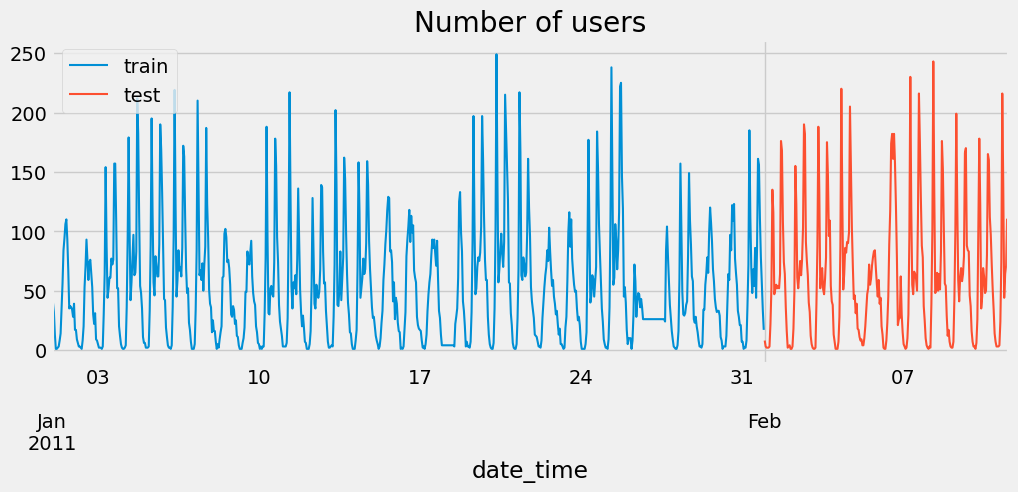

In [57]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_train['users'].plot(ax=ax, label='train')
data_test['users'].plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.legend();

## Forecaster

In [58]:
# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = Ridge(random_state=123),
                 lags      = 24
             )

In [59]:
# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )








100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 225.0

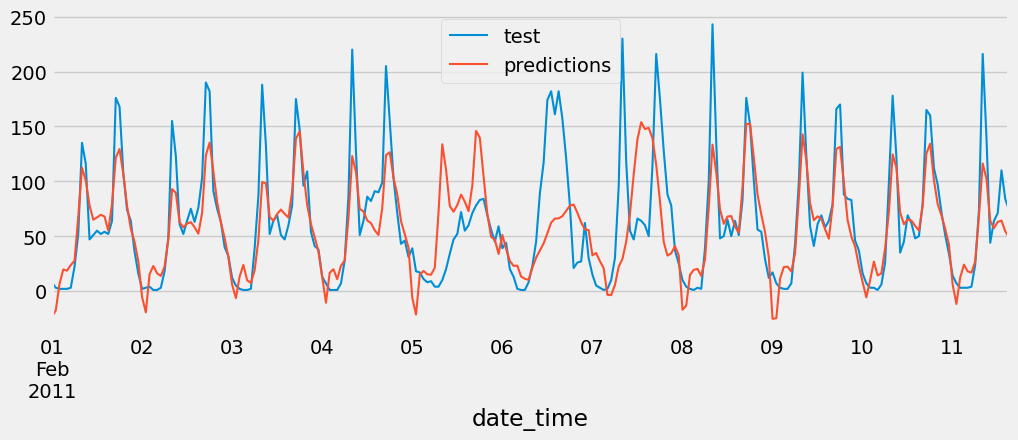

In [60]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

The graph above shows that some predictions are negative.

In [10]:
# Negative predictions
predictions[predictions.pred < 0]

,pred
2011-02-01 00:00:00,-23.337236
2011-02-01 01:00:00,-17.691405
2011-02-02 00:00:00,-5.243456
2011-02-02 01:00:00,-19.363139
2011-02-03 01:00:00,-6.441943
2011-02-04 01:00:00,-10.579940
2011-02-05 00:00:00,-6.026119
2011-02-05 01:00:00,-21.396841
2011-02-07 04:00:00,-3.412043
2011-02-07 05:00:00,-3.701964


## Modeling time series in logarithmic scale

In [11]:
# Transform data into a logarithmic scale
# =============================================================================
data_log = np.log1p(data)
data_train_log = np.log1p(data_train)
data_test_log  = np.log1p(data_test)

In [12]:
# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
             )

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data_log['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_log.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 205.61it/s]


In [13]:
# Revert the transformation
# ==============================================================================
predictions = np.expm1(predictions)
predictions.head(4)

,pred
2011-02-01 00:00:00,7.936823
2011-02-01 01:00:00,4.210682
2011-02-01 02:00:00,3.009993
2011-02-01 03:00:00,3.083922


In [14]:
metric = mean_squared_error(y_true=data_test['users'], y_pred=predictions)
print(f"Backtesting metric: {metric}")

Backtesting metric: 1991.9332571759887


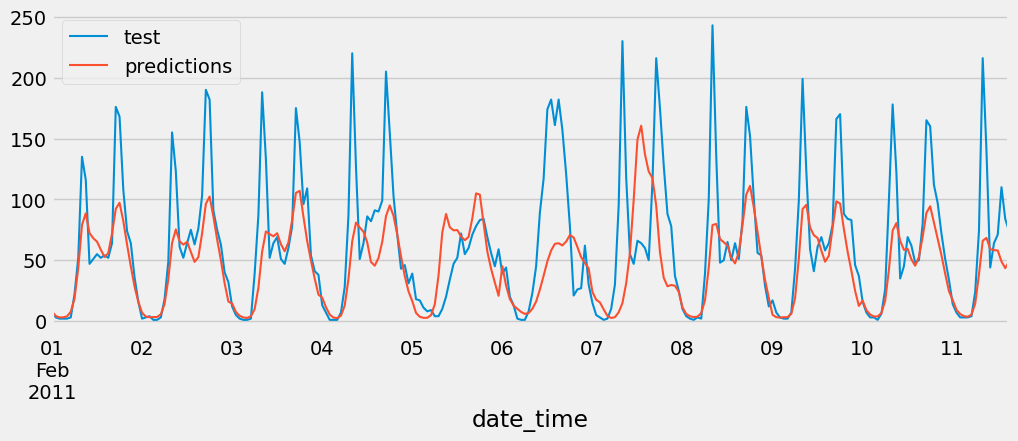

In [15]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

## Include a logarithmic transformer as part of the forecaster

Using scikit-learn [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) it is possible to include custom transformers in the forecaster object, for example, a logarithmic transformation. If the `FunctionTransformer` has an inverse function, the output of the predict method is automatically transformed back to the original scale.

In [16]:
# Create a custom transformer
# =============================================================================
transformer_y = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(random_state=123),
                 lags             = 24,
                 transformer_y    = transformer_y,
                 transformer_exog = None
             )
forecaster.fit(data['users'])

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

print(f"Backtesting metric: {metric}")
predictions.head()

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/11 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 162.58it/s]

Backtesting metric: 1991.9332571759887


,pred
2011-02-01 00:00:00,7.936823
2011-02-01 01:00:00,4.210682
2011-02-01 02:00:00,3.009993
2011-02-01 03:00:00,3.083922
2011-02-01 04:00:00,3.865169


## Usage of link functions

Now we will use some of the linear models with different link functions available in scikit learn.

In [40]:
from sklearn.linear_model import GammaRegressor, TweedieRegressor, PoissonRegressor

In [63]:
# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = GammaRegressor(alpha=1, max_iter=100000),
                 lags          = 20,
             )

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )












100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 228

In [64]:
metric = mean_squared_error(y_true=data_test['users'], y_pred=predictions)
print(f"Backtesting metric: {metric}")

Backtesting metric: 3509.611511054638


In [65]:
predictions.head(5)

,pred
2011-02-01 00:00:00,6.685826
2011-02-01 01:00:00,10.238446
2011-02-01 02:00:00,11.950440
2011-02-01 03:00:00,9.193984
2011-02-01 04:00:00,6.372388


In this case the gamma regressor model performed poorly, but if we look to the negative results:

In [67]:
# Negative predictions
predictions[predictions.pred < 0]

,pred


No negative predictions arised.

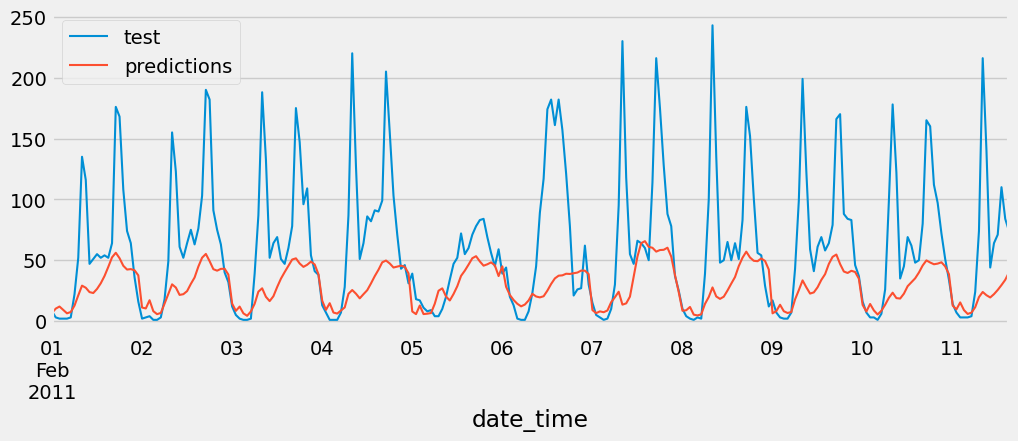

In [66]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

## Usage of XGBoost objective functions

Now we will use XGBoost but we will force the objective function to reg:gamma.

In [74]:
from xgboost import XGBRegressor

In [71]:
param_grid_reg = {
            'tree_method': 'hist',
            'objective': 'reg:gamma'
        }


In [73]:
# Create forecaster and train
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = XGBRegressor(**param_grid_reg),
                 lags          = 24,
             )

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True  
                      )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.83it/s]


In [75]:
metric = mean_squared_error(y_true=data_test['users'], y_pred=predictions)
print(f"Backtesting metric: {metric}")

Backtesting metric: 1665.3412504571495


Performance is much better than Ridge Regression and if we look to the predictions:

In [77]:
# Negative predictions
predictions[predictions.pred < 0]

,pred


No negative values arise. 

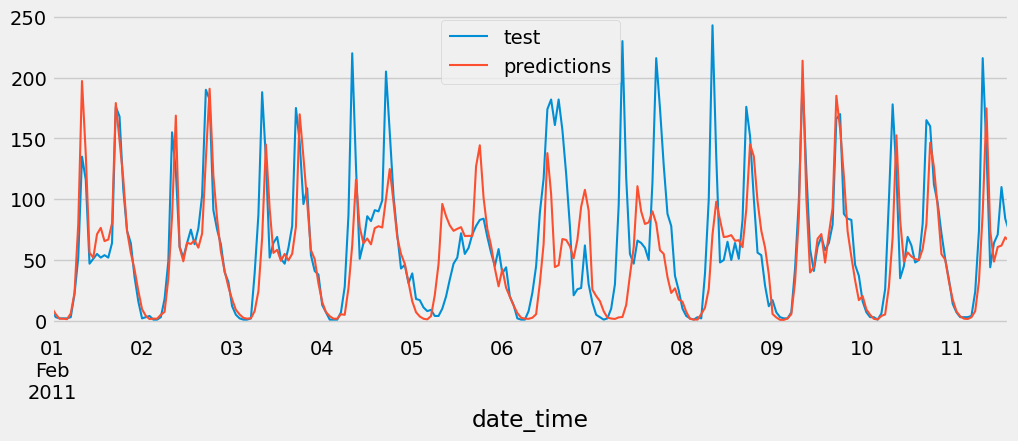

In [78]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [15]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>